In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import os
# Get current case (current directory)
case = os.path.basename(os.getcwd())
print(case)

tjet_Le1B_HGLE


In [4]:
# Load in ODT data
ODT_Tvals = np.loadtxt(r'./T_ODT.txt')
ODT_COvals = np.loadtxt(r'./CO_ODT.txt')
ODT_OHvals = np.loadtxt(r'./OH_ODT.txt')
ODT_CO2vals = np.loadtxt(r'./CO2_ODT.txt')
ODT_hrvals = np.loadtxt(r'./hr_ODT.txt')
ODT_xs = np.loadtxt(r'./xVals.txt')
ODT_ts = np.loadtxt(r'./tVals.txt')

xx,tt = np.meshgrid(ODT_xs,ODT_ts[:39])

# Load in queried data
Tqueried = np.loadtxt(r'./Tqueried.txt')
COqueried = np.loadtxt(r'./COqueried.txt')
OHqueried = np.loadtxt(r'./OHqueried.txt')
CO2queried = np.loadtxt(r'./CO2queried.txt')
hrqueried = np.loadtxt(r'./hrqueried.txt')

In [5]:
# Function for plotting side-by-side and error plots
def sidebyside(odtdata, apdata, ODT_xs, ODT_ts, phi = "phi", units='units', maxError = None, lines = None):
    print(f"CASE = {case}")

    xx, tt = np.meshgrid(ODT_xs, ODT_ts[:39])

    # Plot direct comparison
    plt.rcParams.update({'font.size': 14})
    fig=plt.figure(figsize=(8,8))
    ax = plt.subplot(1, 2, 1)
    ax.set_title("ODT")
    contour1 = ax.contourf(xx,tt,odtdata.T,100, cmap='inferno')
    contour1.set_edgecolor("face")
    levels = contour1.levels
    ax.set_xlabel('x (m)')
    ax.set_ylabel('t (s)')
    ax=plt.subplot(1, 2, 2)
    ax.set_title("Table-queried")
    contour2 = ax.contourf(xx, tt, apdata.T, 100, cmap = 'inferno', levels = levels)
    contour2.set_edgecolor("face")
    ax.set_xlabel('x (m)')
    ax.set_yticks([])
    ax.set_yticklabels([])
    plt.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.13, 0.05, 0.7])
    cbar = fig.colorbar(contour2, cax=cbar_ax)
    cbar.set_label(f'{phi} ({units})', rotation=270, labelpad=20)
    plt.show();

def error(odtdata, apdata, ODT_xs, ODT_ts, phi = "phi", units='units', maxError = None, lines = None):
    print(f'CASE = {case}')
    
    xx, tt = np.meshgrid(ODT_xs, ODT_ts[:39])
    tick_locator = ticker.MaxNLocator(nbins=7)

    # Plot error plot
    fig=plt.figure(figsize=(5,8))
    ax = plt.subplot(1, 1, 1)
    ax.set_title(rf"Error ($\frac{{|\Delta|}}{{\bar{{\phi_{{odt}}}}}}$)")
    errs = odtdata.T - apdata.T
    relErrs = np.abs(errs/np.mean(odtdata.T))*100
    if maxError:
        levels = np.linspace(0, maxError, 101)
        contour = ax.contourf(xx,tt,relErrs, 100, cmap='inferno', levels = levels)
    else:
        contour = ax.contourf(xx,tt,relErrs, 100, cmap='inferno')
    # Set colorbar format string
    contour.set_edgecolor("face")
    cbar = plt.colorbar(contour, ax = ax)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.set_label(rf'% Error', rotation=270, labelpad=20)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('t (s)')
    plt.tight_layout()
    plt.show();

In [6]:
def slices(ODT, queried, ODT_xs, ODT_ts, lines = [0.01, 0.2, 0.4, 0.6], phi = "phi", units = "units", save = False, formatString = '%.4g'):
    xx, tt = np.meshgrid(ODT_xs, ODT_ts[:39])

    plt.rcParams.update({'font.size': 14})
    fig, axs = plt.subplot_mosaic("""AB
                                AC
                                AD
                                AE""", 
                                width_ratios=[1, 1.5], height_ratios=[1, 1, 1, 1],
                                figsize=(6, 6), layout='constrained', 
                                gridspec_kw={'hspace': 0.0, 'wspace': 0.1})

    axs['A'].set_title(f'{phi} ({units})');
    axs['A'].set_ylabel('Time (s)')
    axs['A'].set_xlabel('Position (m)')
    contour1 = axs['A'].contourf(xx, tt, ODT.T, 100, cmap = 'inferno', vmin=np.min(ODT))
    levels = contour1.levels
    contour2 = axs['A'].contourf(xx, tt, queried.T, 100, cmap = 'inferno', vmin=np.min(ODT), levels = levels)
    cbar = plt.colorbar(contour2, ax=axs['A'], pad=0.1, format = ticker.FormatStrFormatter(formatString))
    #cbar.set_label(f'{phi} ({units})', rotation=270, labelpad=15)
    zmin, zmax = np.min(ODT), np.max(ODT)
    lines = [0.01, 0.2, 0.4, 0.6]
    for i, line in enumerate(lines):
        axs['A'].plot(ODT_xs, line * np.ones(len(ODT_xs)), '--', color = 'white')
        timeInd = np.argmin(np.abs(ODT_ts - line))
        ax = axs[list(axs)[len(lines) - i]]
        ax.plot(ODT_xs, ODT.T[timeInd], '-', color = 'b', label= 'ODT')
        ax.plot(ODT_xs, queried.T[timeInd], '.', color = 'r', markersize=2, label='Queried')
        ax.set_ylim(zmin, zmax*1.05)
        ax.tick_params(left = False, labelleft=False)
        if i != 0.0:
            ax.tick_params(bottom=False, top=False, labelbottom=False)
            ax.sharex(axs['A'])
        if i == len(lines) - 1:
            ax.legend()
            ax.set_title("Comparison")
        elif i == 0.0:
            ax.set_xlabel('Position (m)')

    if save:
        plt.savefig(f'./{case}_{phi}_comparison.pdf', dpi=300)
    plt.show()

# Temperature

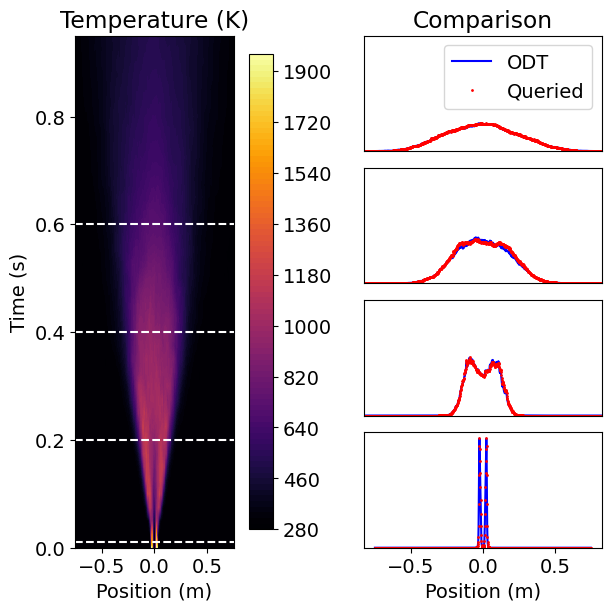

In [7]:
#sidebyside(ODT_Tvals, Tqueried, ODT_xs, ODT_ts, phi = "Temperature", units = "K", maxError = 100)
slices(ODT_Tvals, Tqueried, ODT_xs, ODT_ts, lines = [0.01, 0.2, 0.4, 0.6], phi = "Temperature", units = 'K', save = True)

# CO

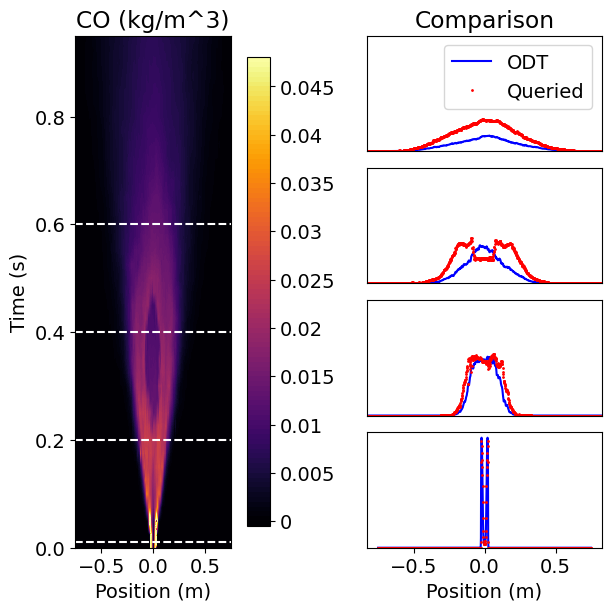

In [6]:
#sidebyside(ODT_COvals, COqueried, ODT_xs, ODT_ts, phi = "CO", units = "kg/m^3", maxError = 1000)
slices(ODT_COvals, COqueried, ODT_xs, ODT_ts, lines = [0.01, 0.2, 0.4, 0.6], phi = "CO", units = "kg/m^3", save = True)

# CO2

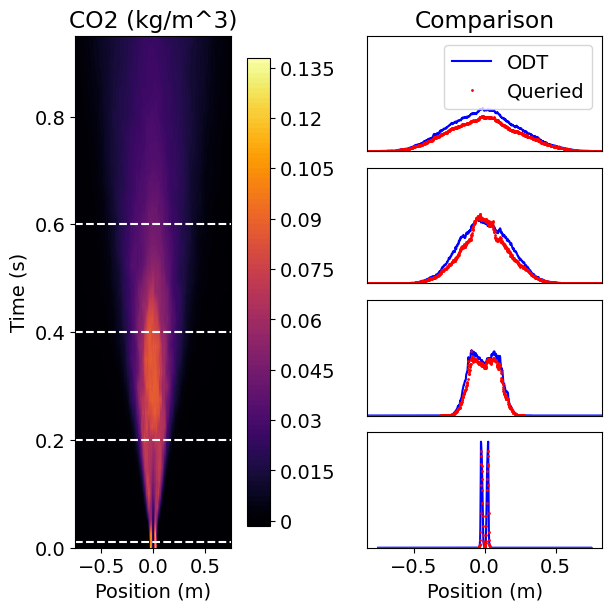

In [7]:
#sidebyside(ODT_CO2vals, CO2queried, ODT_xs, ODT_ts, phi = "CO2", units = "kg/m^3", maxError = 1000)
slices(ODT_CO2vals, CO2queried, ODT_xs, ODT_ts, lines = [0.01, 0.2, 0.4, 0.6], phi = "CO2", units = "kg/m^3", save = True)

# OH

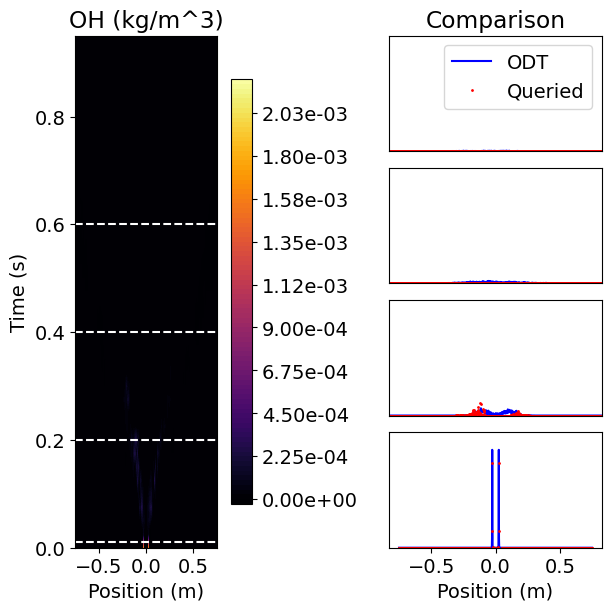

In [8]:
#sidebyside(ODT_OHvals, OHqueried, ODT_xs, ODT_ts, phi = "OH", units = "kg/m^3", maxError = 1000)
slices(ODT_OHvals, OHqueried, ODT_xs, ODT_ts, lines = [0.01, 0.2, 0.4, 0.6], phi = "OH", units = "kg/m^3", formatString='%.2e', save = True)

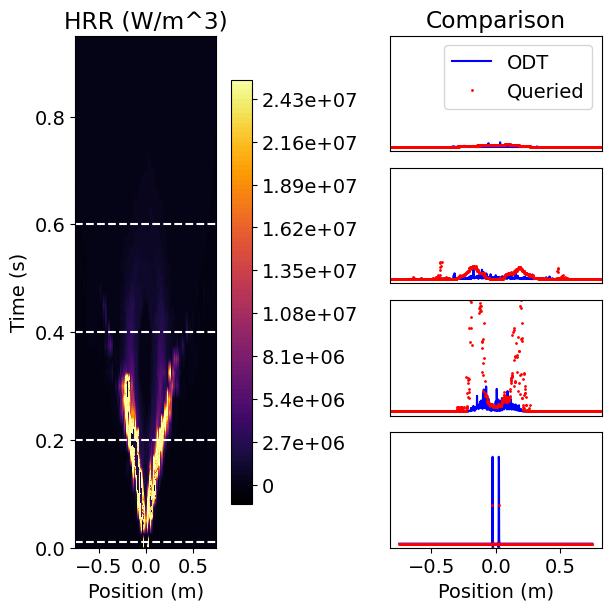

In [9]:
#sidebyside(ODT_hrvals, hrqueried, ODT_xs, ODT_ts, phi = "HRR", units = "W/m^3", maxError = 1e4)
slices(ODT_hrvals, hrqueried, ODT_xs, ODT_ts, lines = [0.01, 0.2, 0.4, 0.6], phi = "HRR", units = "W/m^3", save = True)